In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score, mean_absolute_error
from sklearn.exceptions import NotFittedError

In [2]:
data = pd.read_csv('E:/Final Dissertation/Cleaned_Dataset/NO2_sensor_and_council.csv')
data.head()

,Datetime,NO2_ppb_sensor,NO2_µg/m³_council
0,2024-08-15 15:00:00,5.083429,10.53788
1,2024-08-19 11:00:00,2.796090,21.97463
2,2024-08-19 12:00:00,2.472661,19.66528
3,2024-08-19 13:00:00,7.702129,14.77406
4,2024-08-19 14:00:00,1.452424,15.36216


In [3]:
X = data[['NO2_ppb_sensor']].values
y = data['NO2_µg/m³_council'].values

| **Data** | **Split** |
|----------|-----------|
| **Train Set** | 70% of the Cleaned dataset |
| **Test Set** | 30% of the Cleaned dataset |

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
display(X_train[0:5])
print()
display(X_train_scaled[0:5])
print()
print()
display(X_test[0:5])
display(X_test_scaled[0:5])

array([[2.64740058],
       [0.54764795],
       [2.47266105],
       [0.56236447],
       [0.37980413]])

array([[ 0.43998907],
       [-0.74091593],
       [ 0.34171521],
       [-0.73263933],
       [-0.83531162]])

array([[1.46094132],
       [0.10452187],
       [5.08342942],
       [1.75736312],
       [0.80743062]])

array([[-0.22727794],
       [-0.99013091],
       [ 1.81001647],
       [-0.06056974],
       [-0.59481364]])

#### Experimented List of Models and Parameters

In [7]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'AdaBoost': AdaBoostRegressor(random_state=42)
}

params = {
    'Linear Regression': {
        'poly__degree': [1, 2, 3]
    },
    'Ridge': {
        'ridge__alpha': [0.001, 0.01, 0.1],
        'poly__degree': [1, 2, 3]
    },
    'Lasso': {
        'lasso__alpha': [0.001, 0.01, 0.1],
        'poly__degree': [1, 2, 3]
    },
    'ElasticNet': {
        'elasticnet__alpha': [0.001, 0.01, 0.1],
        'elasticnet__l1_ratio': [0.1, 0.5, 0.9]
    },
    'Random Forest': {
        'randomforest__n_estimators': [50, 100, 150, 200],
        'randomforest__max_depth': [5, 7, 10]
    },
    'Gradient Boosting': {
        'gradientboosting__n_estimators': [50, 100, 150, 200],
        'gradientboosting__learning_rate': [0.001, 0.01, 0.1],
        'gradientboosting__max_depth': [3, 5, 7]
    },
    'XGBoost': {
        'xgboost__n_estimators': [50, 100, 150, 200],
        'xgboost__learning_rate': [0.001, 0.01, 0.1],
        'xgboost__max_depth': [3, 5, 7],
        'xgboost__subsample': [0.6, 0.8, 1.0]
    },
    'K-Nearest Neighbors': {
        'k-nearestneighbors__n_neighbors': [3, 5, 7, 9],
        'k-nearestneighbors__weights': ['uniform', 'distance'],
        'k-nearestneighbors__p': [1, 2]
    },
    'AdaBoost': {
        'adaboost__n_estimators': [50, 100, 150, 200],
        'adaboost__learning_rate': [0.001, 0.01, 0.1],
        'adaboost__loss': ['linear', 'square', 'exponential']
    }
}

polynomial_models = ['Linear Regression', 'Ridge', 'Lasso']

#### 1. polynomial_models is the list of models for which a polynomial feature transformation is required
#### 2. We create a pipeline for those models to transform the features before feeding them to the model.
#### 3. We prefer a Grid Search CV over a Random Search CV due to the small dataset size. As exhaustive hyperparameter tuning is necessary.
#### 4. neg_root_mean_squared_error is used for scoring, while R2 is used for selecting the best model under baseline models.

In [8]:
best_models = []
best_score = float('-inf')
best_model_name = ''
best_params = {}

for model_name in models:
    print(f"Training {model_name}...")
    steps = []

    if model_name in polynomial_models:
        steps.append(('poly', PolynomialFeatures(include_bias=False)))
        
    model_param_key = model_name.lower().replace(' ', '')
    steps.append((model_param_key, models[model_name]))
    pipeline = Pipeline(steps)
    
    grid_search = GridSearchCV(pipeline, params[model_name], cv=5, scoring='neg_root_mean_squared_error', refit=True, n_jobs=-1, verbose=True)
    
    try:
        grid_search.fit(X_train_scaled, y_train)
        model_score = grid_search.best_score_
        
        best_models.append({
            'name': model_name,
            'model': grid_search.best_estimator_,
            'params': grid_search.best_params_,
            'rmse': model_score
        })

    except (ValueError, NotFittedError) as e:
        print(f"Skipped {model_name} due to error: {str(e)}")

Training Linear Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Training Ridge...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training Lasso...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training ElasticNet...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Training Gradient Boosting...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Training XGBoost...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Training K-Nearest Neighbors...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Training AdaBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


## Results

In [9]:
results = []
for model in best_models:
    result = {}
    result['name'] = model['name']
    result['params'] = model['params']
    test_predictions = model['model'].predict(X_test_scaled)
    test_rmse = root_mean_squared_error(y_test, test_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    result['rmse'] = test_rmse
    result['mse'] = test_mse
    result['r2'] = test_r2
    result['mae'] = test_mae
    result['comparison_df'] = pd.DataFrame({'Actual': y_test, 'Predicted': test_predictions})
    results.append(result)

#### For showcasing model with the best R2

In [10]:
results = sorted(results, key=lambda x: x['r2'], reverse=True)

Results For Model: AdaBoost
Best Hyperparameters: {'randomforest__max_depth': 5, 'randomforest__n_estimators': 50}
Test RMSE: 3.5747
Test MSE: 12.7786
Test R2: 0.2106
Test MAE: 2.7340


,Actual,Predicted
0,10.86300,12.659306
1,11.44631,12.735999
2,10.53788,13.231047
3,11.79534,12.579603
4,8.97919,11.989201
5,12.96675,13.884037
6,7.97513,10.945880
7,21.97463,13.563717


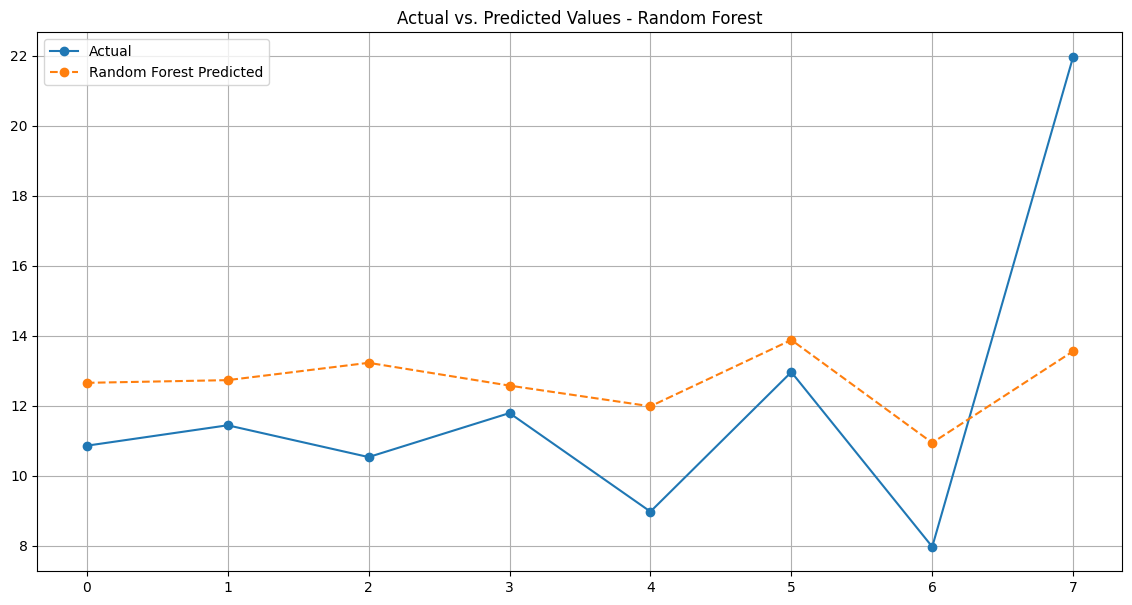


Results For Model: Random Forest
Best Hyperparameters: {'k-nearestneighbors__n_neighbors': 7, 'k-nearestneighbors__p': 1, 'k-nearestneighbors__weights': 'uniform'}
Test RMSE: 3.7706
Test MSE: 14.2176
Test R2: 0.1217
Test MAE: 2.6351


,Actual,Predicted
0,10.86300,11.599314
1,11.44631,12.054897
2,10.53788,13.509763
3,11.79534,13.017296
4,8.97919,11.433334
5,12.96675,13.039834
6,7.97513,12.054897
7,21.97463,13.039834


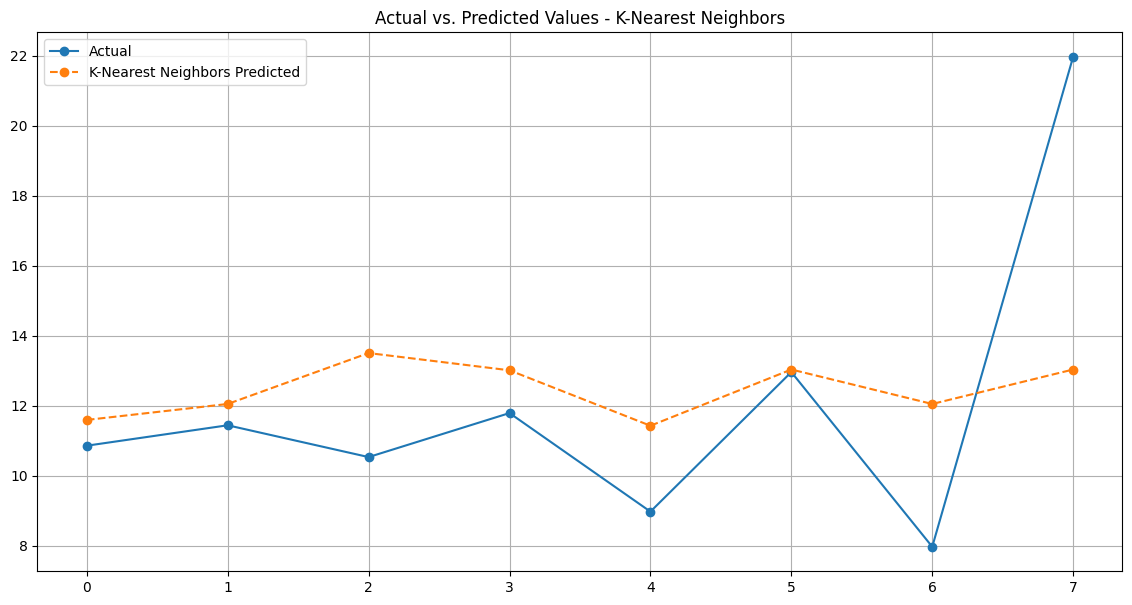


Results For Model: K-Nearest Neighbors
Best Hyperparameters: {'poly__degree': 1}
Test RMSE: 3.9573
Test MSE: 15.6599
Test R2: 0.0326
Test MAE: 2.8937


,Actual,Predicted
0,10.86300,12.560473
1,11.44631,12.190857
2,10.53788,13.547580
3,11.79534,12.641246
4,8.97919,12.382395
5,12.96675,12.877696
6,7.97513,12.284585
7,21.97463,12.924293


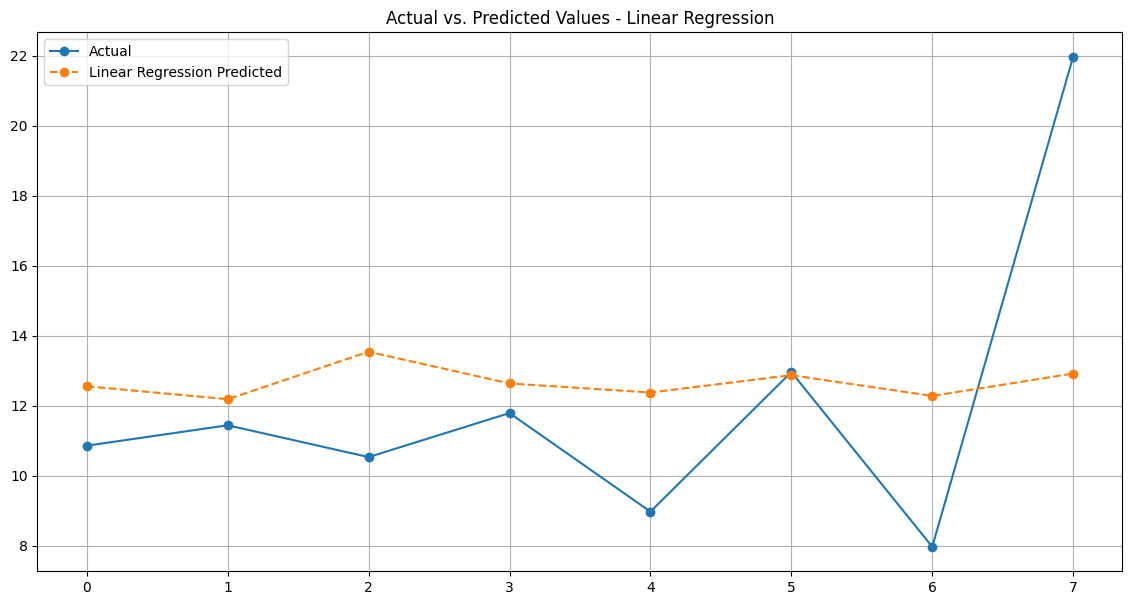


Results For Model: Linear Regression
Best Hyperparameters: {'poly__degree': 1, 'ridge__alpha': 0.001}
Test RMSE: 3.9573
Test MSE: 15.6600
Test R2: 0.0326
Test MAE: 2.8937


,Actual,Predicted
0,10.86300,12.560480
1,11.44631,12.190885
2,10.53788,13.547528
3,11.79534,12.641248
4,8.97919,12.382412
5,12.96675,12.877684
6,7.97513,12.284608
7,21.97463,12.924278


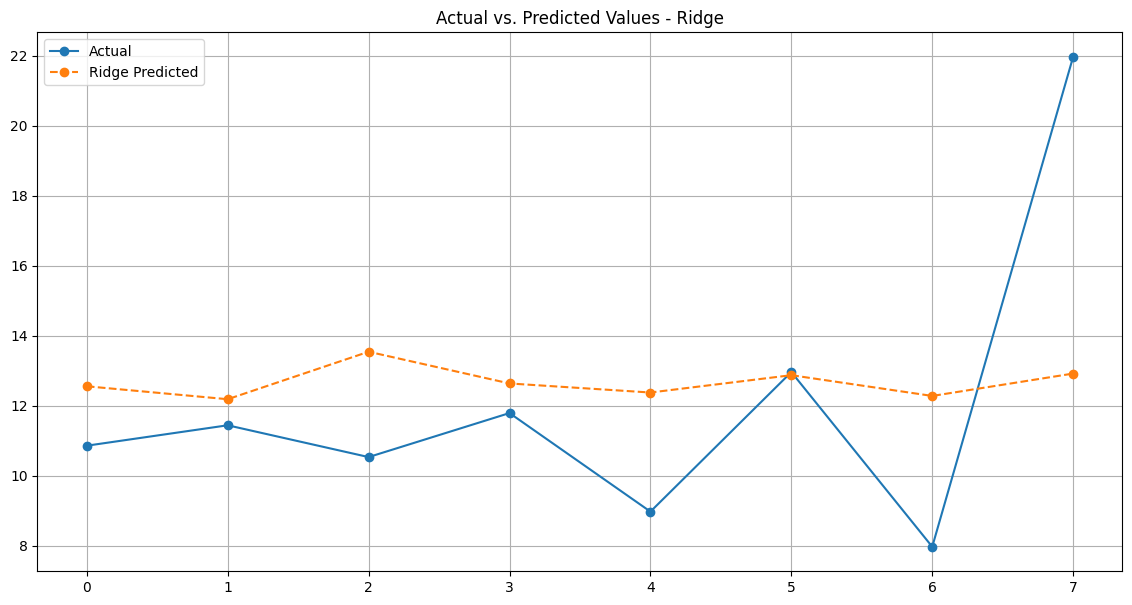


Results For Model: Ridge
Best Hyperparameters: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.1}
Test RMSE: 3.9574
Test MSE: 15.6607
Test R2: 0.0325
Test MAE: 2.8938


,Actual,Predicted
0,10.86300,12.560595
1,11.44631,12.191387
2,10.53788,13.546610
3,11.79534,12.641279
4,8.97919,12.382714
5,12.96675,12.877468
6,7.97513,12.285012
7,21.97463,12.924013


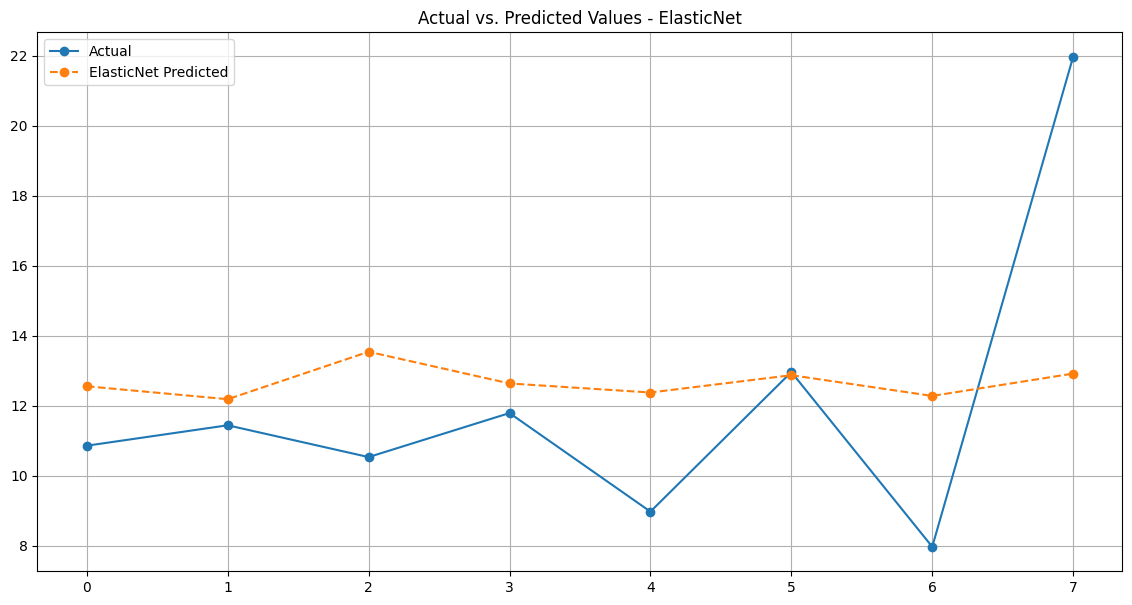


Results For Model: ElasticNet
Best Hyperparameters: {'lasso__alpha': 0.001, 'poly__degree': 1}
Test RMSE: 3.9574
Test MSE: 15.6614
Test R2: 0.0325
Test MAE: 2.8939


,Actual,Predicted
0,10.86300,12.560700
1,11.44631,12.191847
2,10.53788,13.545770
3,11.79534,12.641307
4,8.97919,12.382990
5,12.96675,12.877269
6,7.97513,12.285382
7,21.97463,12.923770


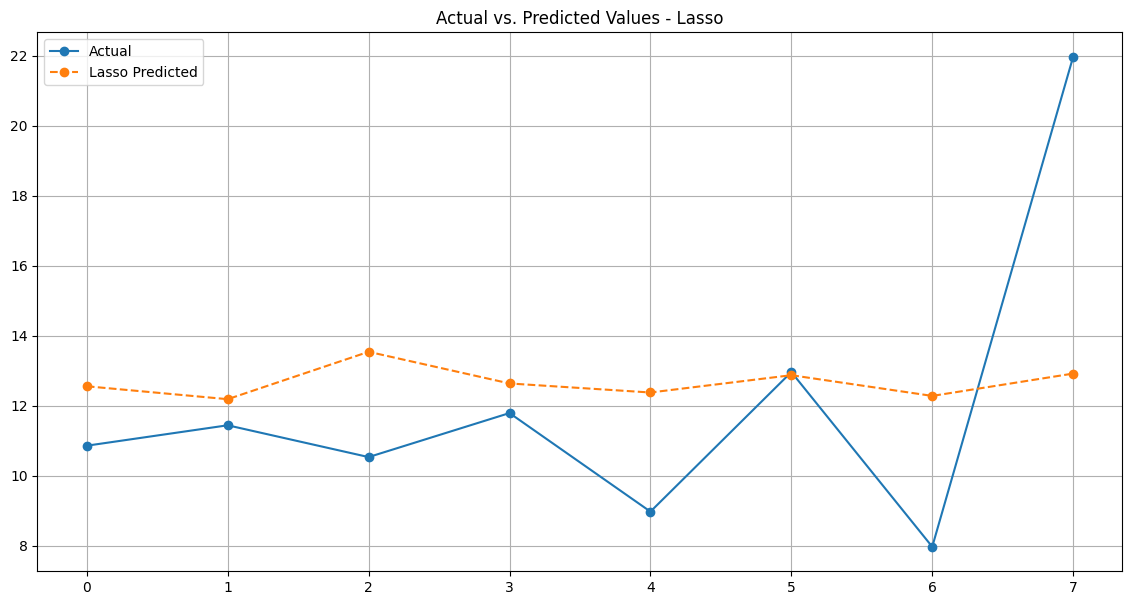


Results For Model: Lasso
Best Hyperparameters: {'adaboost__learning_rate': 0.01, 'adaboost__loss': 'square', 'adaboost__n_estimators': 50}
Test RMSE: 4.0584
Test MSE: 16.4706
Test R2: -0.0175
Test MAE: 2.7208


,Actual,Predicted
0,10.86300,12.920987
1,11.44631,12.158715
2,10.53788,13.746090
3,11.79534,12.887859
4,8.97919,9.739410
5,12.96675,12.211313
6,7.97513,10.854120
7,21.97463,11.674218


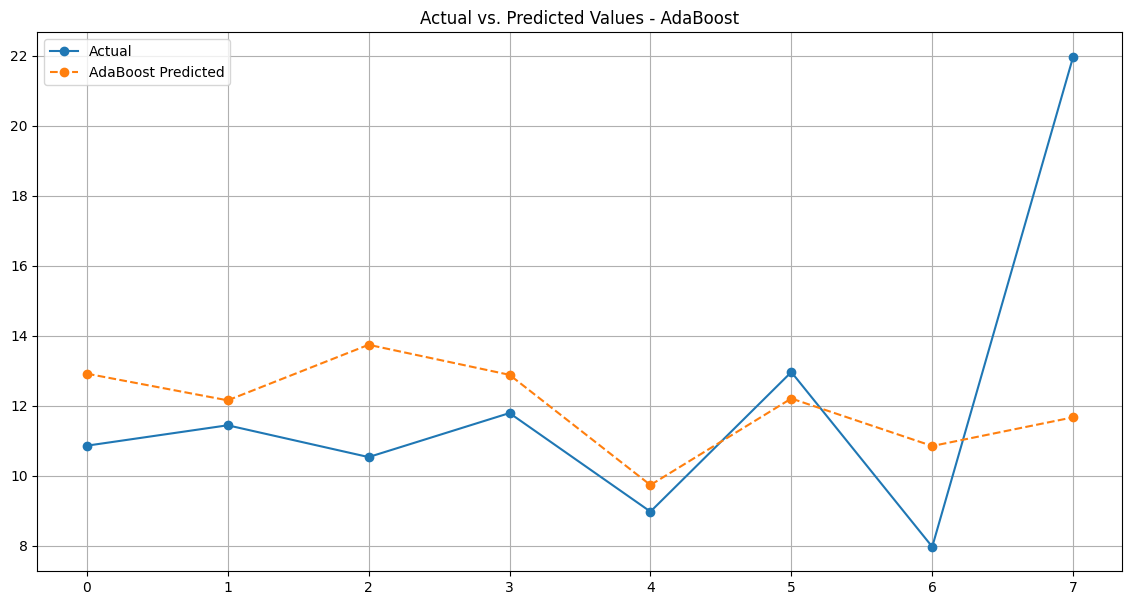


Results For Model: AdaBoost
Best Hyperparameters: {'gradientboosting__learning_rate': 0.001, 'gradientboosting__max_depth': 7, 'gradientboosting__n_estimators': 50}
Test RMSE: 4.0593
Test MSE: 16.4782
Test R2: -0.0180
Test MAE: 2.9943


,Actual,Predicted
0,10.86300,12.612722
1,11.44631,12.733104
2,10.53788,12.723072
3,11.79534,12.664514
4,8.97919,12.527568
5,12.96675,12.565596
6,7.97513,12.480208
7,21.97463,12.565596


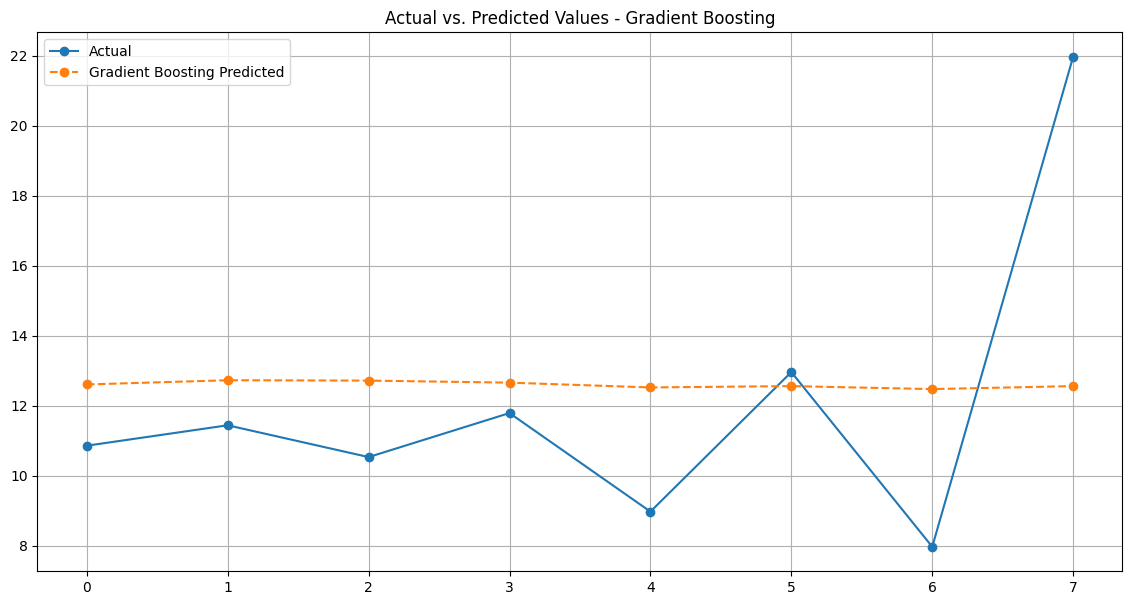


Results For Model: Gradient Boosting
Best Hyperparameters: {'xgboost__learning_rate': 0.001, 'xgboost__max_depth': 3, 'xgboost__n_estimators': 50, 'xgboost__subsample': 1.0}
Test RMSE: 4.0800
Test MSE: 16.6466
Test R2: -0.0284
Test MAE: 2.9828


,Actual,Predicted
0,10.86300,12.701151
1,11.44631,12.634854
2,10.53788,12.722718
3,11.79534,12.701151
4,8.97919,12.540314
5,12.96675,12.843334
6,7.97513,12.634854
7,21.97463,12.573683


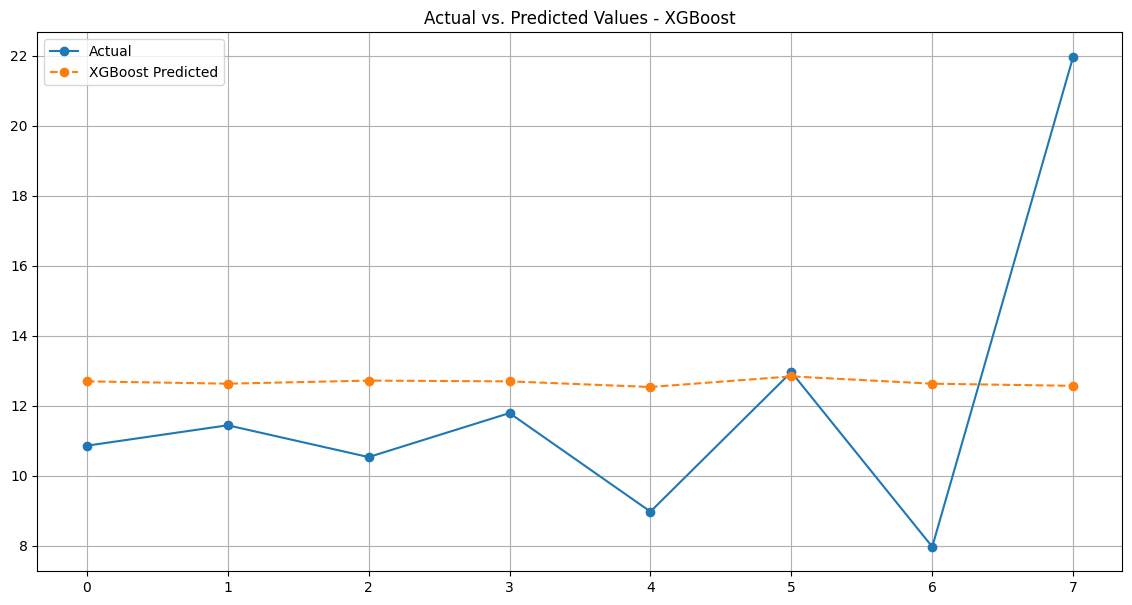

In [11]:
for result in results:
    print(f"Results For Model: {model_name}")
    model_name = result['name']
    print(f"Best Hyperparameters: {result['params']}")
    test_rmse = result['rmse']
    test_mse = result['mse']
    test_r2 = result['r2']
    test_mae = result['mae']
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test R2: {test_r2:.4f}")
    print(f"Test MAE: {test_mae:.4f}")

    comparison_df = result['comparison_df']
    display(comparison_df)

    plt.figure(figsize=(14, 7))
    plt.plot(comparison_df.index, comparison_df['Actual'], label='Actual', marker='o')
    plt.plot(comparison_df.index, comparison_df['Predicted'], label=f'{model_name} Predicted', linestyle='--', marker='o')
    plt.title(f'Actual vs. Predicted Values - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()
    print()

## Model Evaluation

In [12]:
final_scores_df = pd.DataFrame({
    'Model': [result['name'] for result in results],
    'RMSE': [result['rmse'] for result in results],
    'MSE': [result['mse'] for result in results],
    'R2': [result['r2'] for result in results],
    'MAE': [result['mae'] for result in results]
})

display(final_scores_df)

,Model,RMSE,MSE,R2,MAE
0,Random Forest,3.574714,12.778577,0.210563,2.734048
1,K-Nearest Neighbors,3.770627,14.217630,0.121661,2.635066
2,Linear Regression,3.957262,15.659919,0.032558,2.893710
3,Ridge,3.957267,15.659962,0.032556,2.893716
4,ElasticNet,3.957362,15.660717,0.032509,2.893831
5,Lasso,3.957450,15.661410,0.032466,2.893936
6,AdaBoost,4.058398,16.470592,-0.017523,2.720773
7,Gradient Boosting,4.059333,16.478183,-0.017992,2.994316
8,XGBoost,4.080029,16.646640,-0.028399,2.982819
